In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle
import collections

from datetime import datetime
start_real = datetime.now()

In [5]:
PATH='data/'
!mkdir -p {PATH}
!ls {PATH}

models			train_nospcl_val20_text20.csv
test_nospcl_val20.csv	train.tsv
test.tsv		val_nospcl_val20.csv
tmp			val_nospcl_val20_text20.csv
train_nospcl_val20.csv


In [3]:
tag = 'nospcl_val20_text20'
text_tag = 'nospcl_val20_text10'

In [84]:
train_text = pd.read_csv(f'{PATH}/train_{tag}.csv', sep=',')
val_text = pd.read_csv(f'{PATH}/val_{tag}.csv', sep=',')

In [85]:
%%time
list_cols = ['category_name', 'name', 'item_description']
for df in [train_text, val_text]:
    df[list_cols] = df[list_cols].apply(lambda x: x.apply(eval))

CPU times: user 30.1 s, sys: 86.9 ms, total: 30.1 s
Wall time: 30.1 s


In [86]:
train_text = train_text.sample(frac=0.5)
val_text = val_text.sample(frac=0.5)

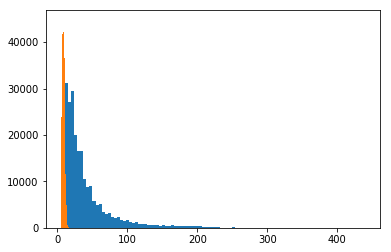

In [9]:
hist1 = plt.hist(train_text['item_description'].apply(lambda x: len(x)), 100)
hist2 = plt.hist(train_text['name'].apply(lambda x: len(x)), bins=30)

In [89]:
class JoinTextDatasetFromDataFrames(torchtext.data.Dataset):
    def __init__(self, df, text_field, col, newline_eos=True, **kwargs):
        fields = [('text', text_field)]
        #text = []

        #text += text_field.preprocess(df[col].str.cat(sep=' <eos> '))
        text = [txt for row in df[col] for txt in row]
        if (newline_eos): text.append('<eos>')

        examples = [torchtext.data.Example.fromlist([text], fields)]

        super().__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, train_df=None, val_df=None, test_df=None, **kwargs):
        train_data = None if train_df is None else cls(train_df, **kwargs)
        val_data = None if val_df is None else cls(val_df, **kwargs)
        test_data = None if test_df is None else cls(test_df, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)
    

class LanguageModelDataFromList(LanguageModelData):
    @classmethod
    def from_dataframes(cls, path, field, col, train_df, val_df, test_df=None, bs=64, bptt=70, **kwargs):
        trn_ds, val_ds, test_ds = JoinTextDatasetFromDataFrames.splits(text_field=field, col=col,
                                    train_df=train_df, val_df=val_df, test_df=test_df)

        return cls(path, field, trn_ds, val_ds, test_ds, bs, bptt, **kwargs)


In [90]:
bs,bptt = 128,50
min_freq=10
em_sz = 100  # size of each embedding vector
nh = 200     # number of hidden activations per layer
nl = 3       # number of layers
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [91]:
%%time
text_col = 'item_description'
# already lowerd and tokenized separately 
ITEM_DES = data.Field()
id_md = LanguageModelDataFromList.from_dataframes('', ITEM_DES, text_col, train_text, 
                                                         val_text, val_text, bs=bs, bptt=bptt, min_freq=min_freq)

id_learner = id_md.get_model(opt_fn, em_sz, nh, nl, 
                            dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
id_learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
id_learner.clip=0.3

CPU times: user 1.98 s, sys: 59.6 ms, total: 2.04 s
Wall time: 2.12 s


In [92]:
id_md.val_ds.examples[0].text

['<category_name>',
 "['Kids', 'Diapering', 'Disposable Diapers']",
 '<name>',
 'diapers',
 'size',
 '3',
 '&',
 '4',
 '<item_description>',
 'they',
 'are',
 'all',
 'huggies',
 'size',
 '3',
 '...',
 'it',
 "'s",
 '27',
 'diapers',
 'total',
 'my',
 'baby',
 "'s",
 'butt',
 'will',
 'not',
 'allow',
 'pampers',
 'on',
 'it',
 '.',
 'this',
 'pack',
 'has',
 '18',
 'left',
 'in',
 'it',
 '.',
 'size',
 '4',
 'all',
 'for',
 '[rm]',
 '<eos>',
 '<category_name>',
 "['Women', 'Athletic Apparel', 'Pants, Tights, Leggings']",
 '<name>',
 'bundle',
 'of',
 'pants',
 '/',
 'tanks',
 '<item_description>',
 '2',
 'small',
 'tanks',
 'from',
 'forever',
 '21',
 'and',
 'xs',
 'pants',
 'from',
 'pink',
 '.',
 'both',
 'are',
 'in',
 'excellent',
 'condition',
 'other',
 'than',
 'the',
 'pictured',
 'light',
 'marks',
 'on',
 'the',
 'p',
 'and',
 'i',
 '<eos>',
 '<category_name>',
 "['Women', 'Sweaters', 'Other']",
 '<name>',
 'women',
 "'s",
 'vineyard',
 'vines',
 'shep',
 'shirt',
 'bundle'

In [13]:
#id_learner.lr_find()
#id_learner.sched.plot()

In [93]:
id_learner.fit(2.0e-2, 2, wds=1e-6, cycle_len=1, cycle_mult=2)

1 1


A Jupyter Widget

  0%|          | 1/740 [00:00<10:05,  1.22it/s, loss=9.48]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1511320797808/work/torch/lib/THC/generic/THCStorage.cu:66

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/deb/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/deb/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/deb/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



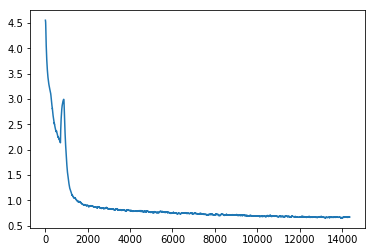

In [11]:
id_learner.sched.plot_loss()

In [12]:
train_text.shape

(237065, 15)

In [13]:
def proc_str(s): return simple_tok(s)
def num_str(field, s): return field.numericalize([s])

def sample_model(m, field, s, l=50):
    t = num_str(field, s)
    m[0].bs=1
    m.eval()
    m.reset()
    res,*_ = m(t)
    print('...', end='')

    for i in range(l):
        n=res[-1].topk(2)[1]
        n = n[1] if n.data[0]==0 else n[0]
        word = field.vocab.itos[n.data[0]]
        print(word, end=' ')
        if word=='<eos>': break
        res,*_ = m(n[0].unsqueeze(0))

    m[0].bs=bs

In [18]:
s = val_text[text_col].iloc[200][:20]
' '.join(s) 

"['<category_name>', "

In [17]:
id_learner.model

SequentialRNN (
  (0): RNN_Encoder (
    (encoder): Embedding(97, 100, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout (
      (embed): Embedding(97, 100, padding_idx=1)
    )
    (rnns): ModuleList (
      (0): WeightDrop (
        (module): LSTM(100, 200, dropout=0.05)
      )
      (1): WeightDrop (
        (module): LSTM(200, 200, dropout=0.05)
      )
      (2): WeightDrop (
        (module): LSTM(200, 100, dropout=0.05)
      )
    )
    (dropouti): LockedDropout (
    )
    (dropouths): ModuleList (
      (0): LockedDropout (
      )
      (1): LockedDropout (
      )
      (2): LockedDropout (
      )
    )
  )
  (1): LinearDecoder (
    (decoder): Linear (100 -> 97)
    (dropout): LockedDropout (
    )
  )
)

In [18]:
sample_model(id_learner.model, ITEM_DES, s)

...<name> men 's nike air max <item_description> size 8 men 's . <eos> 

In [23]:
pickle.dump(ITEM_DES, open(f'{PATH}models/{text_col}_{text_tag}.pkl','wb'))
id_learner.save_encoder(f'{text_col}_{text_tag}')
!mv models/{text_col}_{text_tag}.h5 {PATH}/models/ 

In [24]:
bs2,bptt2 = 256,20
min_freq2=10
em_sz2 = 40  # size of each embedding vector
nh2 = 70     # number of hidden activations per layer
nl2 = 2       # number of layers
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [25]:
%%time
text_col = 'name'
# already lowerd and tokenized separately 
NAME = data.Field()
nm_md = LanguageModelDataFromList.from_dataframes('', NAME, text_col, train_text, 
                                                         val_text, val_text, bs=bs2, bptt=bptt2, min_freq=min_freq2)

nm_learner = nm_md.get_model(opt_fn, em_sz2, nh2, nl2, 
                            dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
nm_learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
nm_learner.clip=0.3

CPU times: user 782 ms, sys: 28.2 ms, total: 810 ms
Wall time: 809 ms


In [26]:
#nm_learner.lr_find()
#nm_learner.sched.plot()

In [27]:
nm_learner.fit(1.0e-1, 2, wds=1e-6, cycle_len=1, cycle_mult=3)

1 1


A Jupyter Widget

[ 0.       4.10751  3.9908 ]                                
[ 1.       3.8897   3.73344]                                
[ 2.       3.66019  3.51876]                                
[ 3.       3.55014  3.44068]                                



In [29]:
pickle.dump(NAME, open(f'{PATH}models/{text_col}_{text_tag}.pkl','wb'))
nm_learner.save_encoder(f'{text_col}_{text_tag}')
!mv models/{text_col}_{text_tag}.h5 {PATH}/models/ 

In [30]:
stop_real = datetime.now()
execution_time_real = stop_real-start_real 
print(execution_time_real)

0:29:23.600449


In [10]:
bs2,bptt2 = 1024,5
min_freq2=1
em_sz2 = 40  # size of each embedding vector
nh2 = 20     # number of hidden activations per layer
nl2 = 1       # number of layers
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

text_col = 'category_name'
# already lowerd and tokenized separately 
NAME = data.Field()
cat_md = LanguageModelDataFromList.from_dataframes('', NAME, text_col, train_text, 
                                                         val_text, val_text, bs=bs2, bptt=bptt2, min_freq=min_freq2)

cat_learner = cat_md.get_model(opt_fn, em_sz2, nh2, nl2, 
                            dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
cat_learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
cat_learner.clip=0.3

In [11]:
cat_learner.fit(1.0e-1, 2, wds=1e-6, cycle_len=1, cycle_mult=3)

1 1


A Jupyter Widget

[ 0.       2.37099  1.90859]                                 
[ 1.       2.02457  1.87869]                               
[ 2.       1.93274  1.84798]                               
[ 3.       1.90228  1.83725]                                



In [14]:
pickle.dump(NAME, open(f'{PATH}models/{text_col}_{text_tag}.pkl','wb'))
cat_learner.save_encoder(f'{text_col}_{text_tag}')